## Coding Exercise #0514

#### 1. Document classification with LSTM network:

In [1]:
import pandas as pd
import numpy as np
import warnings    
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.reuters import load_data, get_word_index       # Reuters news data. 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1.1. Read in the data:

In [2]:
n_words = 1000                                        # Size of the vocabulary.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words, test_split = 0.3)
n_train_size = X_train.shape[0]

In [3]:
# Check for the shapes.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (7859,)
Training data y shape: (7859,)
--------------------------------------------------
Test data X shape: (3369,)
Test data y shape: (3369,)
--------------------------------------------------


#### 1.2. Explore the data:

In [4]:
# Number of unique values of y = Number of categories of the newswires.
n_cat = pd.Series(y_train).nunique()
n_cat

46

In [5]:
# Print out an observation (document) contained in X.
# It is encoded as integers (indices).
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
# Let's check for length of the first 100 documents.
# We notice that the length is not uniform.
print([len(a) for a in X_train[0:100]])

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64]


In [7]:
# Download the dictionary to translate the indices.
my_dict = get_word_index(path='reuters_word_index.json')

In [8]:
# To view the dictionary.
# my_dict

In [9]:
# Exchange the 'key' and 'value'.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [10]:
# Translate each document.
i_news = 10                                        # Document number that can be changed at will.
news = list(pd.Series(X_train[i_news]).apply(lambda x: my_dict_inv[x]))
print(' '.join(news))

the federal gain only growth lt they meeting year reuter company did year an they of of reuter company of of 1987 had of of reuter had profits of pct dlrs


#### 1.3. Data preprocessing:

In [11]:
# Padding: newswire lengths are uniformly matched to maxlen.
# Cut away if longer than maxlen and fill with 0s if shorter than maxlen.
X_train = sequence.pad_sequences(X_train, maxlen = 100)
X_test = sequence.pad_sequences(X_test, maxlen = 100)

In [12]:
# Apply one-hot-encoding to the y variable.
y = np.concatenate([y_train,y_test],axis=0)
y = to_categorical(y,46)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 1.4. Define the model:

In [13]:
n_neurons = 100                   # Neurons within each memory cell.
n_input = 100                     # Dimension of the embeding space. 

In [14]:
# LSTM network model.
my_model = Sequential()
my_model.add(Embedding(n_words, n_input))           # n_words = vocabulary size, n_input = dimension of the embedding space.
my_model.add(LSTM(units=n_neurons, return_sequences=False, input_shape=(None, n_input), activation='tanh'))
my_model.add(Dense(n_cat, activation='softmax'))

In [15]:
# View the summary.
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         100000    
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 185046 (722.84 KB)
Trainable params: 185046 (722.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 1.5. Define the optimizer and compile:

In [16]:
n_epochs = 20                      # Number of epochs.
batch_size = 20                    # Size of each batch.
learn_rate = 0.001                 # learning rate.  

In [17]:
# Optimizer and compilation.
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 1.6. Train the model and visualize the history:

In [18]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose = 1)

Epoch 1/20
315/315 [==============================] - 16s 45ms/step - loss: 2.3225 - accuracy: 0.4155 - val_loss: 1.9454 - val_accuracy: 0.5070
Epoch 2/20
315/315 [==============================] - 14s 45ms/step - loss: 1.8668 - accuracy: 0.5348 - val_loss: 1.6830 - val_accuracy: 0.5579
Epoch 3/20
315/315 [==============================] - 15s 47ms/step - loss: 1.7236 - accuracy: 0.5620 - val_loss: 1.6361 - val_accuracy: 0.5725
Epoch 4/20
315/315 [==============================] - 16s 49ms/step - loss: 1.5902 - accuracy: 0.5896 - val_loss: 1.5343 - val_accuracy: 0.6075
Epoch 5/20
315/315 [==============================] - 17s 54ms/step - loss: 1.5807 - accuracy: 0.5931 - val_loss: 1.5226 - val_accuracy: 0.5916
Epoch 6/20
315/315 [==============================] - 16s 50ms/step - loss: 1.4014 - accuracy: 0.6319 - val_loss: 1.4388 - val_accuracy: 0.6310
Epoch 7/20
315/315 [==============================] - 21s 68ms/step - loss: 1.3313 - accuracy: 0.6580 - val_loss: 1.3774 - val_accuracy:

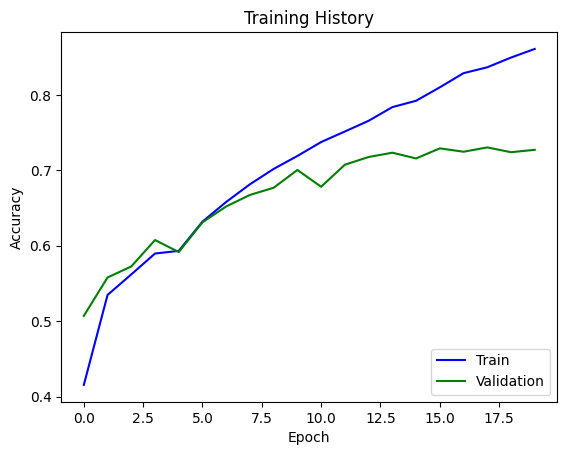

In [19]:
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 1.7. Testing: 

In [20]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.706


In [21]:
# Lưu mô hình sau khi huấn luyện
my_model.save('my_model61.h5')


In [31]:
from tensorflow.keras.models import load_model

# Tải lại mô hình đã huấn luyện
my_model = load_model('my_model61.h5')


In [32]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = my_model.evaluate(X_test, y_test, verbose=0)

# In ra kết quả
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.4021
Test Accuracy: 0.7061


In [33]:
from sklearn.metrics import classification_report
import numpy as np

# Dự đoán các nhãn cho tập test
y_pred = np.argmax(my_model.predict(X_test), axis=1)

# In ra báo cáo phân loại chi tiết
print(classification_report(np.argmax(y_test, axis=1), y_pred))


106/106 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.44      0.65      0.52        17
           1       0.60      0.74      0.66       159
           2       0.35      0.21      0.27        28
           3       0.89      0.92      0.91      1203
           4       0.76      0.84      0.80       722
           5       0.00      0.00      0.00         8
           6       0.81      0.57      0.67        23
           7       0.33      0.25      0.29         4
           8       0.62      0.45      0.52        51
           9       0.50      0.73      0.59        33
          10       0.78      0.62      0.69        40
          11       0.54      0.56      0.55       136
          12       0.44      0.18      0.26        22
          13       0.37      0.27      0.31        60
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        10
          16       0.73  